# Example 1: $H^1$ and $L^2$ (Semi-)Inner Products of Harmonic Functions

Suppose that $\phi$ is a harmonic function on a mesh cell $K$ with given 
Dirichlet data $\phi|_{\partial K}$.
Given another harmonic function $\eta$, we wish to compute the $H^1$ 
semi-inner product and $L^2$ inner product
\begin{align*}
	\int_K \nabla\eta\cdot\nabla\phi~dx 
	&= \int_{\partial K} \eta \, \dfrac{\partial\phi}{\partial\mathbf{n}}\;ds~,
	\\[12pt]
	\text{and}\quad
	\int_K \eta \, \phi~dx 
	&= \int_{\partial K} \eta \, \dfrac{\partial\Phi}{\partial\mathbf{n}}\;ds
	- \int_{\partial K} \Phi \, \dfrac{\partial\eta}{\partial\mathbf{n}}\;ds
\end{align*}
where $\Phi$ is an *anti-Laplacian* of $\phi$, that is, $\Delta\Phi=\phi$.
Toward this end, our task is two-fold:
1. Compute the normal derivative $\frac{\partial\phi}{\partial\mathbf{n}}$.
2. Compute an anti-Laplacian $\Phi$.

## Define a Mesh Cell

We will take $K$ to be a unit square with a circular hole,
and create a `cell` object accordingly. 
See `ex0-mesh-building` for details.

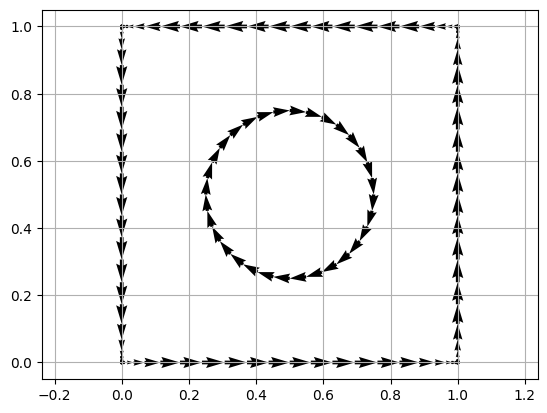

num_edges: 		5
num_holes: 		1
num_pts: 		160
contours: 		[[0, 1, 2, 3], [4]]
ext_pt: 		[-1.0, -1.0]
hole_int_pts (x): 	[0.5]
hole_int_pts (y): 	[0.5]



In [1]:
import puncturedfem as pf
import numpy as np

# define quadrature schemes
n = 16
q_trap = pf.quad.quad.quad(qtype='trap', n=n)
q_kress = pf.quad.quad.quad(qtype='kress', n=n)

# initialize list of edges as empty list
edge_list = []

# bottom: (0,0) to (1,0)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([0,0], [1,0])
edge_list.append(e)

# right: (1,0) to (1,1)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([1,0], [1,1])
edge_list.append(e)

# top: (1,1) to (0,1)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([1,1], [0,1])
edge_list.append(e)

# left: (0,1) to (0,0)
e = pf.mesh.edge.edge(etype='line', q=q_kress)
e.join_points([0,1], [0,0])
edge_list.append(e)

# inner circular boundary
e = pf.mesh.edge.edge(etype='circle', q=q_trap)
e.reverse_orientation()
e.dialate(0.25)
e.translate([0.5, 0.5])
edge_list.append(e)

# check orientation
pf.plot.edges.edges(edge_list, orientation=True)

# define mesh cell
K = pf.mesh.cell.cell(edge_list=edge_list)
print(K)

## Define a Dirichlet Trace

Next we will define a harmonic function $\phi$ by specifying its Dirichlet 
trace. In priciple, we could choose any continuous trace, but for the purposes
of illustration we will choose
$$
	\phi(x) = e^{x_1} \, \cos x_2 + a \ln|x-\xi|
$$
which is harmonic on all of $\mathbb{R}^2$, where $a\in\mathbb{R}$ is a 
fixed constant, and $\xi$ is a fixed point in the interior of the hole of $K$.


In [2]:
# set target value of logarithmic coefficient
a_exact = np.ones((K.num_holes,))

# define trace of \phi
def get_phi_trace(x):
	phi = np.exp(x[0]) * np.cos(x[1])
	for k in range(K.num_holes):
		xi = K.hole_int_pts[:, k] 
		x_xi = np.array([x[0] - xi[0], x[1] - xi[1]])
		x_xi_norm_sq = np.dot(x_xi, x_xi)
		phi += 0.5 * a_exact[k] * np.log(x_xi_norm_sq)
	return phi

We can obtain the values of $\phi$ at the points sampled on the boundary 
$\partial K$ by calling the `evaluate_function_on_boundary` method of the 
`cell` class.

In [3]:
phi_trace = K.evaluate_function_on_boundary(get_phi_trace)

## Find a Harmonic Conjugate

Note that the function $\ln|x-\xi|$ does not have a harmonic conjugate.
However, the Logarithmic Conjugation Theorem states that, given a harmonic 
function $\phi$ and points $\xi_j$ located in the interior of the $j$-th hole,
for $1\leq j\leq m$, then there is a harmonic function $\psi$ with a harmonic 
conjugate and real coefficients $a_1,\dots,a_m$ such that 
\begin{align*}
	\phi(x) = \psi(x) + \sum_{j=1}^m a_m \ln|x-\xi_j|
	~.
\end{align*}
The function `d2n.harmconj.get_harmonic_conjugate()` 
returns the trace of $\hat\psi$,
a harmonic conjugate of $\psi$, and the coeffients $a_1,\dots,a_m$.

**Note**: When $K$ is simply-connected, `get_harmonic_conjugate()` returns 
an empty list `a=[]` for the logarithmic coefficients.

In [4]:
psi_hat_computed, a_computed = \
	pf.d2n.harmconj.get_harmonic_conjugate(K, phi_trace)

Let's compare the computed value of $a$ to its exact value:

In [5]:
print('Computed logarithmic coeffient(s): ', a_computed)
for i in range(len(a_computed)):
	print(f'Error in a[{i}]: %.4e'%np.abs(a_exact[i] - a_computed[i]))

Computed logarithmic coeffient(s):  [1.]
Error in a[0]: 1.0027e-09


## Error in Harmonic Conjugate Computation  

Notice that 
$$
	\widehat\psi(x) = e^{x_1} \, \sin x_2
$$
is a harmonic conjugate of $\psi(x) = e^{x_1} \, \cos x_2$.
Let's compare this to the computed trace of $\widehat\psi$.

In [6]:
# define trace of \hat\psi
def psi_hat(x):
	return np.exp(x[0]) * np.sin(x[1])

# get exact trace of \hat\psi
psi_hat_exact = K.evaluate_function_on_boundary(psi_hat)

We can use call `plot.traceplot.trace()` to plot the trace(s) 
of function(s) on the boundary.

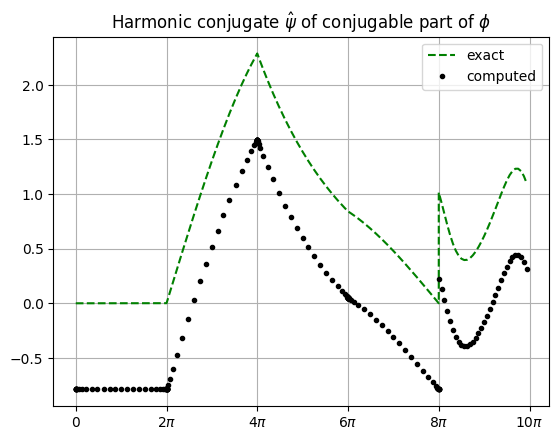

In [7]:
# plot harmonic conjugate
quad_list = [q_trap, q_kress,]
f_trace_list = [psi_hat_exact, psi_hat_computed,]
fmt = ('g--', 'k.')
legend = ('exact','computed')
title = 'Harmonic conjugate $\hat\psi$ of conjugable part of $\phi$'
pf.plot.traceplot.trace(f_trace_list, fmt, legend, title, K, quad_list)

**Note**: A harmonic conjugate is unique only up to an additive constant.
So to compute the error in $\hat\psi$,
we subtract the average distance between the computed and exact values.

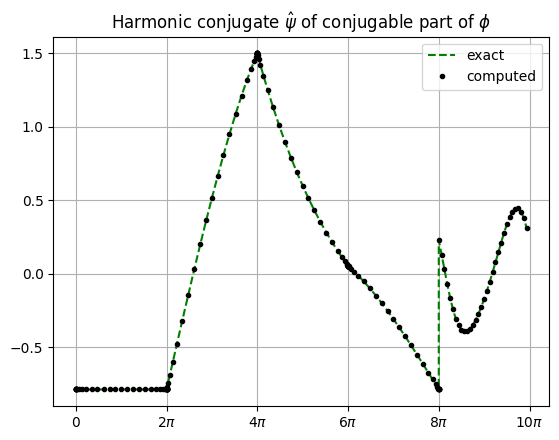

In [8]:
# average distance between values
c = np.sum(psi_hat_exact - psi_hat_computed) / K.num_pts

# plot harmonic conjugate
quad_list = [q_trap, q_kress,]
f_trace_list = [psi_hat_exact - c, psi_hat_computed,]
fmt = ('g--', 'k.')
legend = ('exact','computed')
title = 'Harmonic conjugate $\hat\psi$ of conjugable part of $\phi$'
pf.plot.traceplot.trace(f_trace_list, fmt, legend, title, K, quad_list)

Compute and plot the error in the computed harmonic conjugate.

Error in harmonic conjugate: 6.9156e-06


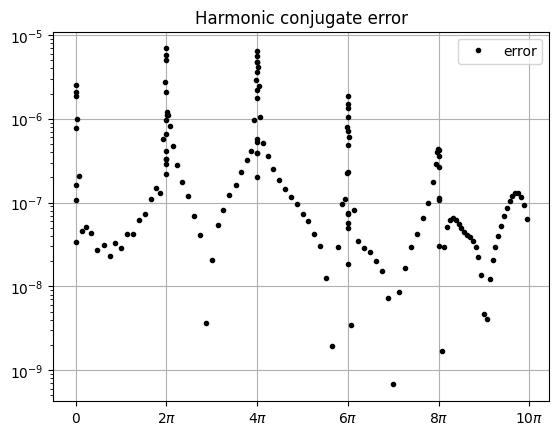

In [9]:
# compute errors in harmonic conjugate
psi_hat_error = np.abs(psi_hat_exact - psi_hat_computed - c)
print('Error in harmonic conjugate: %.4e'%max(psi_hat_error))

# plot harmonic conjugate error
f_trace_list = [psi_hat_error,]
fmt = ('k.',)
legend = ('error',)
title = 'Harmonic conjugate error'
pf.plot.traceplot.trace_log(f_trace_list, fmt, legend, title, K, quad_list)

## Compute the Normal Derivative

Recall that the Cauchy-Riemann equations imply that we can obtain the normal 
derivative of $\psi$ using the tangential derivative of its harmonic conjugate:
$$
	\dfrac{\partial\psi}{\partial\mathbf{n}} 
	= \dfrac{\partial\hat\psi}{\partial\mathbf{t}}
	~.
$$
Furthermore, if $x(t)$ is a parameterization of $\partial K$, we have 
$$
	\dfrac{d}{dt}\hat\psi(x(t)) 
	= \dfrac{\partial\hat\psi(x(t))}{\partial\mathbf{t}} \, |x'(t)|
	~.
$$
We refer to this derivative as a **weighted tangential derivative**.
Similarly, we refer to 
\begin{align*}
	\dfrac{\partial\psi(x(t))}{\partial\mathbf{n}} \, |x'(t)|
\end{align*}
the a **weighted tangential derivative** of $\psi$.
Since $\hat\psi$ is periodic as we traverse each connected component of the 
boundary, a natural choice to compute the weighted tangential derivative 
is to use an FFT-based method, which is indeed how we proceed.

In [10]:
# compute weighted normal derivative with FFT
dpsi_dn_wgt_computed \
	= pf.d2n.trace2tangential.get_weighted_tangential_derivative_from_trace( \
		K, psi_hat_computed)

To find the weighted normal derivative of 
\begin{align*}
	\phi(x) = \psi(x) + \sum_{j=1}^m a_m \ln|x-\xi_j|
	~,
\end{align*}
we need to add the weighted normal derivatives of the logarithmic terms.

In [11]:
lam_x1_trace, lam_x2_trace = pf.d2n.log_terms.get_log_grad(K)
dlam_dn_wgt = pf.d2n.log_terms.get_dlam_dn_wgt(K, lam_x1_trace, lam_x2_trace)
dphi_dn_wgt_computed = dpsi_dn_wgt_computed + dlam_dn_wgt @ a_computed

Let's find the error in this computation. Note that $\phi$ has the gradient
$$
	\nabla\phi(x) = e^{x_1}
	\begin{pmatrix}
		\cos x_2 \\ -\sin x_2
	\end{pmatrix}
	+
	a \, \frac{x-\xi}{|x - \xi|^2}
	~.
$$

Weighted normal derivative error: 1.5605e-05


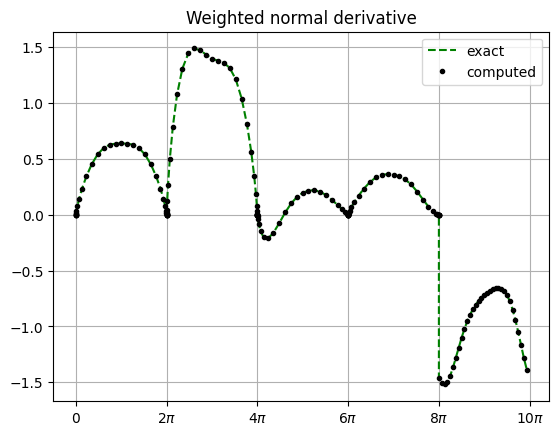

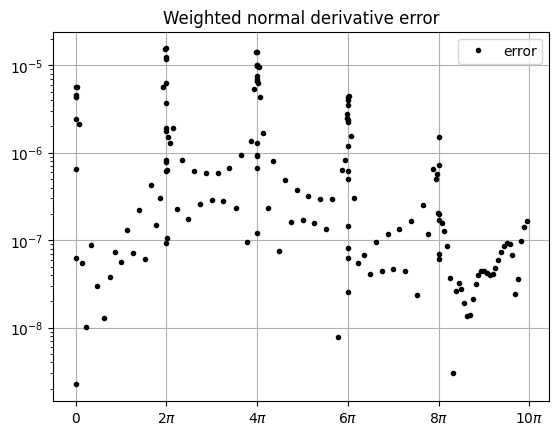

In [12]:
# define the components of the gradient of phi
def get_phi_x1(x):
	phi_x1 = np.exp(x[0]) * np.cos(x[1])
	for k in range(K.num_holes):
		xi = K.hole_int_pts[:, k] 
		x_xi = np.array([x[0] - xi[0], x[1] - xi[1]])
		x_xi_norm_sq = np.dot(x_xi, x_xi)
		phi_x1 += a_exact[k] * x_xi[0] / x_xi_norm_sq
	return phi_x1

def get_phi_x2(x):
	phi_x2 = - np.exp(x[0]) * np.sin(x[1])
	for k in range(K.num_holes):
		xi = K.hole_int_pts[:, k] 
		x_xi = np.array([x[0] - xi[0], x[1] - xi[1]])
		x_xi_norm_sq = np.dot(x_xi, x_xi)
		phi_x2 += a_exact[k] * x_xi[1] / x_xi_norm_sq
	return phi_x2

phi_x1_trace = K.evaluate_function_on_boundary(get_phi_x1)
phi_x2_trace = K.evaluate_function_on_boundary(get_phi_x2)
dphi_dn = K.dot_with_normal(phi_x1_trace, phi_x2_trace)
dphi_dn_wgt_exact = K.multiply_by_dx_norm(dphi_dn)

# compute errors
dphi_dn_wgt_error = np.abs(dphi_dn_wgt_computed - dphi_dn_wgt_exact)
print('Weighted normal derivative error: %.4e'%max(dphi_dn_wgt_error))

# plot exact and computed weighted normal derivatives
quad_list = [q_trap, q_kress,]
f_trace_list = [dphi_dn_wgt_exact, dphi_dn_wgt_computed,]
fmt = ('g--', 'k.')
legend = ('exact','computed')
title = 'Weighted normal derivative'
pf.plot.traceplot.trace(f_trace_list, fmt, legend, title, K, quad_list)

# plot errors
f_trace_list = [dphi_dn_wgt_error,]
fmt = ('k.',)
legend = ('error',)
title = 'Weighted normal derivative error'
pf.plot.traceplot.trace_log(f_trace_list, fmt, legend, title, K, quad_list)

## Test Integration: $H^1$ Seminorm

To check the weighted normal derivative is suitable for computations,
we perform the simple test of computing the $H^1$ semi-norm of $\phi$:
\begin{align*}
	\int_K |\nabla\phi|^2~dx 
	&= \int_{\partial K} \phi \, \dfrac{\partial\phi}{\partial\mathbf{n}}~ds
	\\[12pt]
	&= \int_a^b 
	\phi(x(t)) \, 
	\dfrac{\partial\phi(x(t))}{\partial\mathbf{n}}|x'(t)|~dt
	~,
\end{align*}
where $x(t)$ parameterizes $\partial K$ for $a\leq t\leq b$.
Notice that the weighted normal derivative appears in the integrand.
A simple application of the trapezoid rule yields the $H^1$ seminorm.

In [13]:
h = 2 * np.pi * K.num_edges / K.num_pts
h1_semi_norm_computed = h * np.sum(phi_trace * dphi_dn_wgt_computed)
print(h1_semi_norm_computed)

7.667304830236698


We compare this result to that obtained using *Mathematica*:
\begin{align*}
	\int_K |\nabla\phi|^2 ~dx \approx 7.667305830092
\end{align*}

In [14]:
h1_semi_norm_exact = 7.667305830092
h1_semi_norm_error = np.abs(h1_semi_norm_computed - h1_semi_norm_exact)
print('Error in H^1 semi-norm: %.4e'%h1_semi_norm_error)

Error in H^1 semi-norm: 9.9986e-07


### Convergence Trends

Repeating the experiment above for several values of $n$, we can observe the 
convergence trend in maximum absolute error the harmonic conjugate and weighted
normal derivative, as well as the square $H^1$ seminorm.

| n | hc max abs error | wnd max abs error | square h1 error |
|---|---|---|---|
| 4   | 2.7680e-01 | 3.7064e-01 | 2.2443e-02 |
| 8	  | 1.3887e-03 | 2.3718e-03 | 3.4570e-04 | 
| 16  | 6.9156e-06 | 1.5605e-05 | 9.9986e-07 | 
| 32  | 5.9020e-08 | 2.3206e-07 | 1.1939e-09 | 
| 64  | 3.8949e-10 | 3.0451e-09 | 4.9916e-13 | 
| 128 | 2.5967e-11 | 1.4412e-09 | 7.6383e-14 | 

## Find an Anti-Laplacian

Our second task is to find an anti-Laplacian $\Phi$ such that $\Delta\Phi=\phi$.
Note that
\begin{align*}
	\Lambda(x) = \frac14 |x|^2 \big(\ln|x|-1 \big)
\end{align*}
is an anti-Laplacian of $\lambda(x) = \ln|x|$.
So if $\Psi$ is an anti-Laplacian of $\psi$, then we would have
\begin{align*}
	\Phi(x) = \Psi(x) + \sum_{k=1}^m a_k \Lambda(x-\xi_k)
\end{align*}
is an anti-Laplacian of 
\begin{align*}
	\phi(x) = \psi(x) + \sum_{k=1}^m a_k \ln|x-\xi_k|
	~.
\end{align*}
First, we isolate the trace of $\psi$.

In [15]:
lam_trace = pf.d2n.log_terms.get_log_trace(K)
psi_computed = phi_trace - lam_trace @ a_computed

From the `antilap` module, we call `get_anti_laplacian_harmonic()`.
This function returns the trace of $\Psi$ on the boundary $\partial K$,
as well as its weighted normal derivative 
$\frac{\partial\Psi}{\partial\mathbf{n}}|x'(t)|$.

In [16]:
PSI_computed, dPSI_dn_wgt_computed = \
	pf.antilap.antilap.get_anti_laplacian_harmonic( \
		K, psi_computed, psi_hat_computed, debug=False)

Let's compare the computed values of $\Psi$ to 
\begin{align*}
	\tilde\Psi(x) = \frac14 e^{x_1}
	\big((x_1 - \xi_1)\cos x_2 + (x_2 - \xi_2) \sin x_2\big)~,
\end{align*}
which is an anti-Laplacian of $\psi(x)=e^{x_1}\cos x_2$ for an arbitrary point
$\xi = (\xi_1, \xi_2) \notin K$.

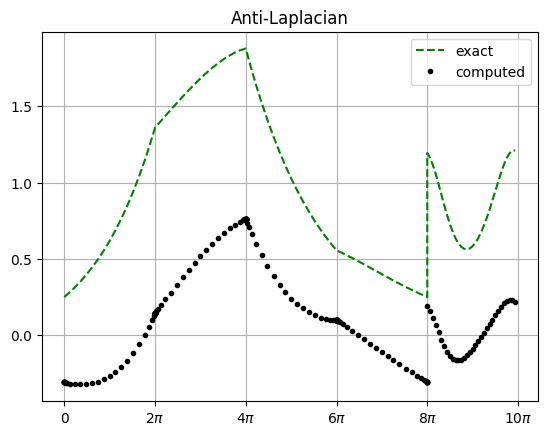

In [17]:
psi_exact = phi_trace - lam_trace @ a_exact

def get_PSI(x):
	y0 = x[0] - K.ext_pt[0]
	y1 = x[1] - K.ext_pt[1]
	return 0.25 * np.exp(x[0]) * (y0 * np.cos(x[1]) + y1 * np.sin(x[1]))

PSI_exact = K.evaluate_function_on_boundary(get_PSI)

quad_list = [q_trap, q_kress,]
f_trace_list = [PSI_exact, PSI_computed]
fmt = ('g--', 'k.')
legend = ('exact','computed')
title = 'Anti-Laplacian'
pf.plot.traceplot.trace(f_trace_list, fmt, legend, title, K, quad_list)

In general, $\Psi$ is unique only up to the addition of a harmonic function.
Indeed, if $\Psi$ and $\tilde\Psi$ are both anti-Laplacians of $\psi$, we have 
\begin{align*}
	\Delta (\Psi - \tilde\Psi) = \psi-\psi = 0
	~.
\end{align*}
However, in this case we can say more. 
Both $\Psi$ and $\widetilde\Psi$ were constructed with
\begin{align*}
	\Psi = \frac14|x - \xi|^2 \rho
	~,\quad 
	\widetilde\Psi = \frac14 |x - \xi|^2 \widetilde\rho
	~,
\end{align*}
where $\rho$ and $\widetilde\rho$ are harmonic functions such that
\begin{align*}
	\rho + (x - \xi) \cdot \nabla\rho
	=
	\psi
	=
	\widetilde\rho + (x - \xi) \cdot \nabla\widetilde\rho
	~.
\end{align*}
As a consequence, it ought to hold that
\begin{align*}
	\Psi - \widetilde\Psi = c \cdot (x - \xi)
\end{align*}
is an affine function.
We will test this conjecture by performing a least squares best linear fit 
on the computed values of $\Psi - \widetilde\Psi$.

max error in anti-Laplacian = 2.9526e-06


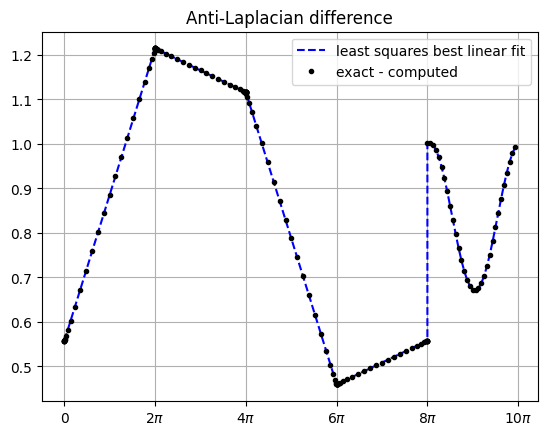

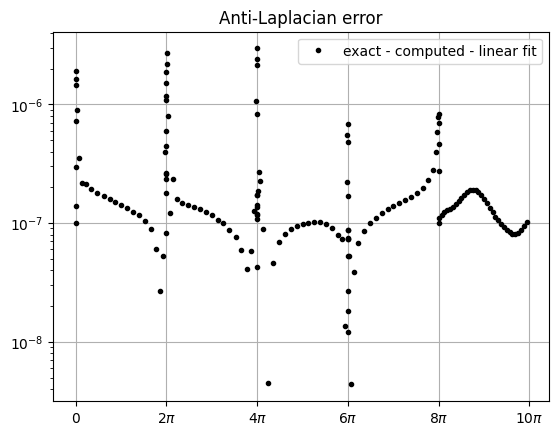

In [18]:
PSI_diff = PSI_exact - PSI_computed

xi = K.ext_pt
x1, x2 = K.get_boundary_points()

X = np.zeros((K.num_pts, 2))
X[:,0] = x1 - xi[0]
X[:,1] = x2 - xi[1]
XX = np.transpose(X) @ X
Xy = np.transpose(X) @ PSI_diff
aa = np.linalg.solve(XX, Xy)
PSI_diff_fit = X @ aa

PSI_diff_error = np.abs(PSI_diff_fit - PSI_diff)
print('max error in anti-Laplacian = %.4e'%(max(PSI_diff_error)))

quad_list = [q_trap, q_kress,]
f_trace_list = [PSI_diff_fit, PSI_diff]
fmt = ('b--','k.')
legend = ('least squares best linear fit', 'exact - computed')
title = 'Anti-Laplacian difference'
pf.plot.traceplot.trace(f_trace_list, fmt, legend, title, K, quad_list)

quad_list = [q_trap, q_kress,]
f_trace_list = [PSI_diff_error,]
fmt = ('k.',)
legend = ('exact - computed - linear fit',)
title = 'Anti-Laplacian error'
pf.plot.traceplot.trace_log(f_trace_list, fmt, legend, title, K, quad_list)

### Incorporate Logarithmic Terms
To obtain $\Phi$, we add the anti-Laplacians of the logarithmic terms, 
and likewise for the weighted normal derivative.

In [19]:
LAM = pf.antilap.log_antilap.get_log_antilap(K)
PHI_computed = PSI_computed + LAM @ a_computed

dLAM_dn_wgt = \
	pf.antilap.log_antilap.get_log_antilap_weighted_normal_derivative(K)
dPHI_dn_wgt_computed = dPSI_dn_wgt_computed + dLAM_dn_wgt @ a_computed

## Test Integration: $L^2$ Norm

We are now prepared to compute the $L^2$ inner product of $\phi$ with a
harmonic function $\eta$:
\begin{align*}
	\int_K \eta \, \phi~dx 
	= \int_K \eta \Delta\Phi \; dx 
	&= \int_{\partial K} \eta \, \dfrac{\partial\Phi}{\partial\mathbf{n}}\;ds
	- \int_{\partial K} \Phi \, \dfrac{\partial\eta}{\partial\mathbf{n}}\;ds
	~.
\end{align*}
We will pick $\eta=\phi$ to compute the square of the $L^2$ norm of $\phi$.

In [20]:
l2_norm_sq_computed = h * np.sum(phi_trace * dPHI_dn_wgt_computed)
l2_norm_sq_computed -= h * np.sum(PHI_computed * dphi_dn_wgt_computed)
print(l2_norm_sq_computed)

0.5459494621659471


As before, we compare this value to that given by *Mathematica*:
\begin{align*}
	\int_K \phi^2 \; dx \approx 0.5459488786732
\end{align*}

In [21]:
l2_norm_sq_exact = 0.5459488786732
l2_norm_sq_error = np.abs(l2_norm_sq_computed - l2_norm_sq_exact)
print('Error in L2 square norm: %.4e'%l2_norm_sq_error)

Error in L2 square norm: 5.8349e-07


### Convergence trends

Repeating the experiment above for several values of $n$, 
we report the maximum pointwise error in $\Psi$ and the absolute error 
in the square $L^2$ norm of $\psi$. 

| n | al max abs error | square l2 error |
|---|---|---|
| 4   | 3.0926e-02 | 1.3259e-02 |
| 8	  | 1.9826e-04 | 2.2124e-04 | 
| 16  | 2.9526e-06 | 5.8349e-07 | 
| 32  | 2.4722e-08 | 7.0181e-10 | 
| 64  | 1.6397e-10 | 2.9365e-13 | 
| 128 | 4.1113e-11 | 5.1070e-15 | 

## Conclusion

We have seen that the $H^1$ semi-inner product and $L^2$ inner product of
harmonic functions $\phi$ and $\eta$ can be computed to high precision using 
only their Dirichlet traces. 
The $H^1$ semi-inner product can be computed by first obtaining the normal 
derivative of $\phi$ via a Nyström method. 
To compute the $L^2$ inner product, we construct an anti-Laplacian of $\phi$, 
whose trace can also be obtained with a Nyström method.